In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None): 
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

In [4]:
!pip install d2l

     |████████████████████████████████| 81kB 3.6MB/s 


In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from torch.optim import lr_scheduler

In [6]:
DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [8]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [9]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [11]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [12]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [13]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
                            dtype=torch.float32)
log_train_labels = np.log(train_labels)

In [14]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 256),
                        nn.ReLU(),
                        #nn.Dropout(p=0.1, inplace=False),
                        nn.Linear(256, 64),
                        nn.ReLU(),
                        nn.Linear(64, 32),
                        nn.ReLU(),
                        nn.Linear(32, 1))
    return net

In [15]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [16]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    #lambda1 = lambda epoch: epoch//30
    #scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        #scheduler.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))

    #print(scheduler.get_last_lr())
    return train_ls, test_ls

In [17]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [18]:
def init_weights(m):
  if type(m) == nn.Linear:
      nn.init.xavier_uniform_(m.weight)

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size, log_values=False):
    train_l_sum, valid_l_sum = 0, 0
    if log_values:
      y_train = np.log(y_train)
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()

        net.apply(init_weights);
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.014272, valid log rmse 0.016846
fold 2, train log rmse 0.012369, valid log rmse 0.017570
fold 3, train log rmse 0.013052, valid log rmse 0.016125
fold 4, train log rmse 0.012994, valid log rmse 0.014068
fold 5, train log rmse 0.012322, valid log rmse 0.017756
5-fold validation: avg train log rmse: 0.013002, avg valid log rmse: 0.016473


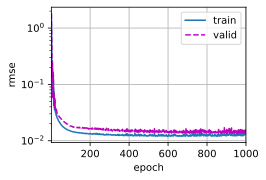

In [20]:
k, num_epochs, lr, weight_decay, batch_size = 5, 1000, .001, 0.075, 512
#k, num_epochs, lr, weight_decay, batch_size = 5, 500, .005, 0.05, 512
LOG_VALUES = True
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size, log_values=LOG_VALUES)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

In [19]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size, log_values=False):
    net = get_net()
    net.apply(init_weights);
    if log_values:
      train_labels = np.log(train_labels)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    if log_values:
      submission['SalePrice'] = (np.exp(submission['SalePrice'])).astype(float)
    submission.to_csv('submission.csv', index=False)

train log rmse 8.122157


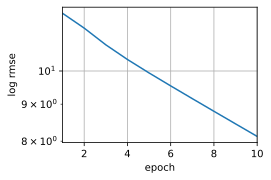

In [22]:
k, num_epochs, lr, weight_decay, batch_size = 5, 10, .001, 0.075, 512
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size, log_values=False)

1.   0.16719
2.   0.15213 (Learning rate: .01)
3. 0.14134



In [ ]:
submission = pd.read_csv('submission.csv')

In [ ]:
submission

,Id,SalePrice
0,1461,118268.726562
1,1462,171593.421875
2,1463,183036.906250
3,1464,198919.781250
4,1465,192822.796875
...,...,...
1454,2915,83774.914062
1455,2916,84458.062500
1456,2917,178161.453125
1457,2918,117605.687500


In [ ]:
log_train_labels

tensor([[12.2477],
        [12.1090],
        [12.3172],
        ...,
        [12.4931],
        [11.8645],
        [11.9016]])

In [ ]:
np.exp(log_train_labels)

tensor([[208499.9531],
        [181499.9531],
        [223499.9219],
        ...,
        [266500.0312],
        [142124.9531],
        [147500.0312]])

In [ ]:
train_labels

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])